In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
df=pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')
df2=pd.read_csv('/kaggle/input/unsw-nb15/UNSW-NB15_1.csv')
df.info()
df.head()
df2.info()
df.head()

/tmp/ipykernel_36/715057061.py:3: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('/kaggle/input/unsw-nb15/UNSW-NB15_1.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


**CNN TRIAL**

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

df = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")

df.drop(columns=["id"], inplace=True, errors="ignore")

X = df.drop(columns=["label", "attack_cat"], errors="ignore")
y = df["label"]

cat_cols = X.select_dtypes(include="object").columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

client_data = np.array_split(X_scaled, 5)
client_labels = np.array_split(y.values, 5)


In [ ]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

for i in range(5):
    client_data[i] = client_data[i].reshape((client_data[i].shape[0], client_data[i].shape[1], 1))

global_model = create_model(input_shape=(X_scaled.shape[1], 1))

global_weights = global_model.get_weights()

EPOCHS = 1
ROUNDS = 3

for round_num in range(ROUNDS):
    print(f"\n🌍 Global Round {round_num+1}")
    local_weights = []
    
    for i in range(5):
        print(f"  🛰️ Client {i+1}")
        local_model = create_model(input_shape=(X_scaled.shape[1], 1))
        local_model.set_weights(global_weights)
        
        local_model.fit(client_data[i], client_labels[i], epochs=EPOCHS, batch_size=32, verbose=0)
        
        local_weights.append(local_model.get_weights())

    new_weights = []
    for weights in zip(*local_weights):
        new_weights.append(np.mean(weights, axis=0))
    
    global_weights = new_weights
    global_model.set_weights(global_weights)


In [ ]:

df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df_test.drop(columns=["id"], inplace=True, errors="ignore")
y_test = df_test["label"]
X_test = df_test.drop(columns=["label", "attack_cat"], errors="ignore")


for col in X_test.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col].astype(str))

X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

loss, acc = global_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\n✅ Final Model Accuracy on Test Set: {acc*100:.2f}%")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (global_model.predict(X_test_scaled) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
!pip install --quiet tensorflow_federated

import tensorflow_federated as tff


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

df = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
df.drop(columns=["id"], inplace=True, errors="ignore")

X = df.drop(columns=["label", "attack_cat"], errors="ignore")
y = df["label"]

for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:

df1 = pd.read_csv("/kaggle/input/unsw-nb15/UNSW-NB15_1.csv")
df2 = pd.read_csv("/kaggle/input/unsw-nb15/UNSW-NB15_2.csv")
df3 = pd.read_csv("/kaggle/input/unsw-nb15/UNSW-NB15_3.csv")
df4 = pd.read_csv("/kaggle/input/unsw-nb15/UNSW-NB15_4.csv")

df_full = pd.concat([df1, df2, df3, df4], ignore_index=True)


SLIDING WINDOW

In [ ]:

def sliding_window(X, y, window_size=20):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# 🔀 Split into 5 clients (WSN nodes)
X_parts = np.array_split(X_scaled, 5)
y_parts = np.array_split(y.values, 5)

client_data, client_labels = [], []
for i in range(5):
    X_seq, y_seq = sliding_window(X_parts[i], y_parts[i])
    if len(X_seq.shape) == 2:
        X_seq = X_seq.reshape((X_seq.shape[0], 10, -1))
    client_data.append(X_seq)
    client_labels.append(y_seq)

# 🔍 Check shape
for i in range(5):
    print(f"Client {i+1} data: {client_data[i].shape}, labels: {client_labels[i].shape}")


In [ ]:
def create_better_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(2),

        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(2),

        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
global_model = create_model(client_data[0].shape[1:])
global_weights = global_model.get_weights()

ROUNDS = 5
EPOCHS = 3

for rnd in range(ROUNDS):
    print(f"\n🌍 Federated Round {rnd+1}")
    local_weights = []
    for i in range(5):
        print(f"  🛰️ Client {i+1}")
        model = create_model(client_data[i].shape[1:])
        model.set_weights(global_weights)
        model.fit(client_data[i], client_labels[i], epochs=EPOCHS, batch_size=32, verbose=0)
        local_weights.append(model.get_weights())

    new_weights = []
    for weights in zip(*local_weights):
        new_weights.append(np.mean(weights, axis=0))
    
    global_weights = new_weights
    global_model.set_weights(global_weights)


In [ ]:

df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df_test.drop(columns=["id"], inplace=True, errors="ignore")
X_test = df_test.drop(columns=["label", "attack_cat"], errors="ignore")
y_test = df_test["label"]

for col in X_test.select_dtypes(include="object").columns:
    X_test[col] = LabelEncoder().fit_transform(X_test[col].astype(str))
X_test_scaled = scaler.transform(X_test)

X_test_seq, y_test_seq = sliding_window(X_test_scaled, y_test.values)
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], -1))


y_pred = (global_model.predict(X_test_seq) > 0.5).astype(int)

# 📊 Report
print("📊 Classification Report:")
print(classification_report(y_test_seq, y_pred))


In [ ]:
cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**MULTI CLASS SETUP**

In [ ]:

df = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
df.drop(columns=["id", "label"], inplace=True, errors="ignore")

df["attack_cat"] = df["attack_cat"].fillna("Normal")

X = df.drop(columns=["attack_cat"])
y = df["attack_cat"]

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Encode target labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)


In [ ]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def sliding_window(X, y, window_size=10):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# Partition into clients
X_parts = np.array_split(X_scaled, 5)
y_parts = np.array_split(y_cat, 5)

client_data, client_labels = [], []
for i in range(5):
    X_seq, y_seq = sliding_window(X_parts[i], y_parts[i], window_size=10)
    client_data.append(X_seq)
    client_labels.append(y_seq)


In [ ]:
def create_multiclass_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(2),
        
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
global_model = create_multiclass_model(client_data[0].shape[1:], num_classes)
global_weights = global_model.get_weights()

ROUNDS = 5
EPOCHS = 2

for rnd in range(ROUNDS):
    print(f"\n🌍 Federated Round {rnd+1}")
    local_weights = []
    
    for i in range(5):
        model = create_multiclass_model(client_data[i].shape[1:], num_classes)
        model.set_weights(global_weights)
        model.fit(client_data[i], client_labels[i], epochs=EPOCHS, batch_size=32, verbose=0)
        local_weights.append(model.get_weights())

    # FedAvg
    global_weights = [np.mean(w, axis=0) for w in zip(*local_weights)]
    global_model.set_weights(global_weights)


**FEDERATION (USING LOCAL CLIENTS)**

In [ ]:
global_model = create_multiclass_model(client_data[0].shape[1:], num_classes)
global_weights = global_model.get_weights()

ROUNDS = 5
EPOCHS = 2

for rnd in range(ROUNDS):
    print(f"\n🌍 Federated Round {rnd+1}")
    local_weights = []
    
    for i in range(5):
        model = create_multiclass_model(client_data[i].shape[1:], num_classes)
        model.set_weights(global_weights)
        model.fit(client_data[i], client_labels[i], epochs=EPOCHS, batch_size=32, verbose=0)
        local_weights.append(model.get_weights())

    # FedAvg
    global_weights = [np.mean(w, axis=0) for w in zip(*local_weights)]
    global_model.set_weights(global_weights)


In [ ]:

df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df_test.drop(columns=["id", "label"], inplace=True, errors="ignore")
df_test["attack_cat"] = df_test["attack_cat"].fillna("Normal")

X_test = df_test.drop(columns=["attack_cat"])
y_test = df_test["attack_cat"]

for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = LabelEncoder().fit_transform(X_test[col].astype(str))

X_test_scaled = scaler.transform(X_test)


y_test_encoded = label_encoder.transform(y_test)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)


X_test_seq, y_test_seq = sliding_window(X_test_scaled, y_test_cat, window_size=10)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Convert from one-hot to integer labels
y_flat = [np.argmax(y, axis=1) for y in client_labels]

# Step 2: Compute weights using all clients’ data (optional: average weights)
y_all = np.concatenate(y_flat)
classes = np.unique(y_all)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_all)
class_weights_dict = dict(zip(classes, class_weights))

print("✅ Computed class weights:")
for i, w in class_weights_dict.items():
    print(f"{i}: {w:.2f}")


In [ ]:
global_model = create_multiclass_model(client_data[0].shape[1:], num_classes)
global_weights = global_model.get_weights()

ROUNDS = 5
EPOCHS = 2

for rnd in range(ROUNDS):
    print(f"\n🌍 Federated Round {rnd+1}")
    local_weights = []

    for i in range(len(client_data)):
        print(f"  🧠 Training client {i}")
        model = create_multiclass_model(client_data[i].shape[1:], num_classes)
        model.set_weights(global_weights)
        
        y_int = np.argmax(client_labels[i], axis=1)
        model.fit(client_data[i], client_labels[i],
                  epochs=EPOCHS,
                  batch_size=32,
                  class_weight=class_weights_dict,
                  verbose=0)
        
        local_weights.append(model.get_weights())

    # FedAvg
    global_weights = [np.mean(w, axis=0) for w in zip(*local_weights)]
    global_model.set_weights(global_weights)


In [ ]:

!pip install keras-losses

from keras_losses import SparseCategoricalFocalLoss
loss_fn = SparseCategoricalFocalLoss(gamma=2.0)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = global_model.predict(X_test_seq, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_seq, axis=1)


print("🔍 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))


In [ ]:
from IPython.display import clear_output
import time

stream_length = 30
stream_X = X_test_seq[:stream_length]
stream_y = y_test_seq[:stream_length]

for i in range(stream_length):
    clear_output(wait=True)
    
    pred = global_model.predict(stream_X[i].reshape(1, 10, -1), verbose=0)
    pred_class = label_encoder.inverse_transform([np.argmax(pred)])
    actual_class = label_encoder.inverse_transform([np.argmax(stream_y[i])])
    
    print(f"📶 Time: {i+1}")
    print("🔍 Sample (first 3 timesteps):")
    print(np.round(stream_X[i][:3].flatten(), 2))
    
    print(f"\n🧠 Prediction: {'❌' if pred_class[0]!='Normal' else '✅'} {pred_class[0]}")
    print(f"🛡️  Actual:    {'❌' if actual_class[0]!='Normal' else '✅'} {actual_class[0]}")
    
    time.sleep(1)


**MULTI CLASS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [ ]:
df = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
df = df.drop(columns=["id", "label"], errors="ignore")
df["attack_cat"] = df["attack_cat"].fillna("Normal")


In [ ]:
X = df.drop(columns=["attack_cat"])
y = df["attack_cat"]

for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1]


In [ ]:
def sliding_window(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = sliding_window(X_scaled, y_categorical)


In [ ]:
y_seq_int = np.argmax(y_seq, axis=1)
X_oversampled, y_oversampled = [], []

unique_classes, counts = np.unique(y_seq_int, return_counts=True)
max_count = max(counts)

for cls in unique_classes:
    idx = np.where(y_seq_int == cls)[0]
    X_cls, y_cls = X_seq[idx], y_seq[idx]
    
    reps = max_count // len(X_cls)
    rem = max_count % len(X_cls)
    
    X_res = np.concatenate([X_cls]*reps + [X_cls[:rem]])
    y_res = np.concatenate([y_cls]*reps + [y_cls[:rem]])
    
    X_oversampled.append(X_res)
    y_oversampled.append(y_res)

X_bal = np.concatenate(X_oversampled)
y_bal = np.concatenate(y_oversampled)


In [ ]:
def create_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inp)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)


In [ ]:
def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[1])
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        weights = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weights * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn


In [ ]:
model = create_model(input_shape=X_bal.shape[1:], num_classes=num_classes)
model.compile(optimizer=Adam(0.001), loss=sparse_categorical_focal_loss(), metrics=['accuracy'])

history = model.fit(X_bal, y_bal, 
                    epochs=10, 
                    batch_size=64, 
                    validation_split=0.2, 
                    verbose=1)


In [ ]:
df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df_test = df_test.drop(columns=["id", "label"], errors='ignore')
df_test["attack_cat"] = df_test["attack_cat"].fillna("Normal")

X_test = df_test.drop(columns=["attack_cat"])
y_test = df_test["attack_cat"]

for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = LabelEncoder().fit_transform(X_test[col].astype(str))

X_test_scaled = scaler.transform(X_test)
y_test_encoded = label_encoder.transform(y_test)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)

X_test_seq, y_test_seq = sliding_window(X_test_scaled, y_test_cat)


In [ ]:
y_pred = model.predict(X_test_seq, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_seq, axis=1)

print("🔍 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap="Blues")
plt.title("📊 Confusion Matrix - Multiclass IDS")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
for i in range(10):
    sample = X_test_seq[i].reshape(1, 10, -1)
    pred = model.predict(sample, verbose=0)
    pred_class = label_encoder.inverse_transform([np.argmax(pred)])[0]
    true_class = label_encoder.inverse_transform([np.argmax(y_test_seq[i])])[0]
    confidence = np.max(pred)

    print(f"\n📶 Time: {i+1}")
    print(f"🔍 Sample (first 3 timesteps):\n{np.round(sample[0][:3].flatten(), 2)}")
    print(f"\n🧠 Prediction: {'✅' if pred_class == true_class else '❌'} {pred_class} ({confidence:.2f})")
    print(f"🛡️  Actual:     ✅ {true_class}")

    if confidence < 0.4:
        print("⚠️ Low confidence — possible unknown attack")
    time.sleep(1)


> **ADAPTIVE**

In [ ]:
adaptive_buffer_X = []
adaptive_buffer_y = []

CONFIDENCE_THRESHOLD = 0.6     # If model confidence < this, retrain
MISCLASSIFY_TRIGGER = True     # Also retrain on wrong predictions
BATCH_UPDATE_INTERVAL = 10     # Retrain after 10 samples in buffer


In [ ]:
def adaptive_update(model, buffer_X, buffer_y, label_encoder):
    if not buffer_X:
        return model
    
    X_adapt = np.array(buffer_X)
    y_adapt = np.array(buffer_y)
    
    # One-hot encode for training
    y_adapt_cat = to_categorical(label_encoder.transform(y_adapt), num_classes=num_classes)

    print(f"\n🔁 Updating model with {len(X_adapt)} new samples...")
    model.fit(X_adapt, y_adapt_cat, epochs=2, batch_size=8, verbose=0)
    print("✅ Model updated.\n")

    # Clear buffer
    buffer_X.clear()
    buffer_y.clear()
    
    return model


In [ ]:
for i in range(len(X_test_seq)):
    sample = X_test_seq[i].reshape(1, 10, -1)
    true_class = label_encoder.inverse_transform([np.argmax(y_test_seq[i])])[0]

   
    pred = model.predict(sample, verbose=0)
    pred_class = label_encoder.inverse_transform([np.argmax(pred)])[0]
    confidence = np.max(pred)

    print(f"\n📶 Time: {i+1}")
    print(f"🧠 Prediction: {'✅' if pred_class == true_class else '❌'} {pred_class} ({confidence:.2f})")
    print(f"🛡️  Actual:     ✅ {true_class}")
    
    if confidence < CONFIDENCE_THRESHOLD or (MISCLASSIFY_TRIGGER and pred_class != true_class):
        print("⚠️ Low confidence or misclassified — adding to update buffer.")
        adaptive_buffer_X.append(sample[0])
        adaptive_buffer_y.append(true_class)

    # Update model every N samples
    if len(adaptive_buffer_X) >= BATCH_UPDATE_INTERVAL:
        model = adaptive_update(model, adaptive_buffer_X, adaptive_buffer_y, label_encoder)

    time.sleep(0.5)  # Simulated delay to mimic real-time


In [ ]:

final_preds = model.predict(X_test_seq, verbose=0)
final_pred_labels = np.argmax(final_preds, axis=1)
true_labels = np.argmax(y_test_seq, axis=1)

print("\n📊 Final Evaluation After Adaptation")
print(classification_report(true_labels, final_pred_labels, target_names=label_encoder.classes_))


In [ ]:
Federation and drift


In [ ]:
from scipy.stats import entropy

def kl_divergence(p, q):
    p = np.asarray(p) + 1e-7  # smooth
    q = np.asarray(q) + 1e-7
    return entropy(p, q)


In [ ]:
from scipy.stats import entropy
import numpy as np

def detect_drift(X_window, baseline_mean):
   
    if len(X_window.shape) == 3:
        X_window = X_window.reshape(-1, X_window.shape[-1])
    
    current_mean = np.mean(X_window, axis=0)

    baseline = np.clip(baseline_mean, a_min=1e-8, a_max=None)
    current = np.clip(current_mean, a_min=1e-8, a_max=None)

    p = baseline / np.sum(baseline)
    q = current / np.sum(current)

    kl = entropy(p, q)

   
    if not np.isfinite(kl):
        return 0.0  

    return kl


In [ ]:
baseline_window = X_test_seq[:1000]
if len(baseline_window.shape) == 3:
    baseline_window = baseline_window.reshape(-1, baseline_window.shape[-1])

baseline_mean = np.mean(baseline_window, axis=0)
baseline_mean = np.clip(baseline_mean, 1e-8, None)  # Prevent 0s


In [ ]:
DRIFT_THRESHOLD = 0.1
window_size = 100

for i in range(0, len(X_test_seq), window_size):
    X_window = X_test_seq[i:i+window_size]
    drift_score = detect_drift(X_window, baseline_mean)
    
    print(f"📊 Drift Score at batch {i//window_size}: {drift_score:.4f}")
    if drift_score > DRIFT_THRESHOLD:
        print("⚠️ Concept Drift Detected! Consider retraining or fine-tuning the model.")



In [ ]:
model.save('adaptive_federated_ids_model.h5')


In [ ]:
import joblib
import json

joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

metadata = {
    "sequence_length": 10,
    "input_shape": list(X_seq_balanced.shape[1:]),
    "num_classes": num_classes
}
with open("model_metadata.json", "w") as f:
    json.dump(metadata, f)


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())

        y_pred = tf.gather(y_pred, y_true, axis=1, batch_dims=1)
        loss = -alpha * (1 - y_pred) ** gamma * tf.math.log(y_pred)
        return tf.reduce_mean(loss)
    return loss_fn


In [ ]:
model = tf.keras.models.load_model(
    'adaptive_federated_ids_model.h5',
    compile=False
)


In [ ]:
model.compile(
    optimizer='adam',
    loss=sparse_categorical_focal_loss(),  # Redefined earlier
    metrics=['accuracy']
)


**LSTM TRY**

In [ ]:
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model


In [ ]:
model.compile(
    optimizer='adam',
    loss=sparse_categorical_focal_loss(),  # Your redefined focal loss
    metrics=['accuracy']
)


In [ ]:
# Simulated real-time input stream using your test sequence
WINDOW_SIZE = 10
DELAY_BETWEEN_STEPS = 0.5  # seconds

label_encoder = joblib.load("label_encoder.pkl")  # for decoding predicted class index
stream = X_test_seq  # 3D shape: (samples, window, features)

print("🚀 Starting Real-Time IDS Simulation...\n")


In [ ]:
from scipy.stats import entropy

# Baseline for drift detection
baseline_window = stream[:500].reshape(-1, stream.shape[2])
baseline_mean = np.mean(baseline_window, axis=0)
baseline_mean = np.clip(baseline_mean, 1e-8, None)

def detect_drift(X_window, baseline_mean):
    current = np.mean(X_window.reshape(-1, X_window.shape[-1]), axis=0)
    current = np.clip(current, 1e-8, None)

    p = baseline_mean / np.sum(baseline_mean)
    q = current / np.sum(current)

    kl = entropy(p, q)
    return kl if np.isfinite(kl) else 0.0

DRIFT_THRESHOLD = 0.2


In [ ]:
for i in range(len(stream)):
    X_window = stream[i]  # Shape: (10, 42)
    X_input = X_window.reshape(1, 10, 42)  # Shape: (1, 10, 42) ✅

    # Prediction
    y_pred = model.predict(X_input, verbose=0)
    y_pred_label = np.argmax(y_pred)
    label = label_encoder.inverse_transform([y_pred_label])[0]

    # Drift detection
    drift_score = detect_drift(X_window, baseline_mean)
    drift_alert = drift_score > DRIFT_THRESHOLD

    print(f"📶 Time Step: {i}")
    print(f"🔍 Predicted Class: {label} ({'⚠️ Drift!' if drift_alert else '✅ Stable'})")
    print(f"📊 Drift Score: {drift_score:.4f}")
    print("-" * 50)

    time.sleep(0.3)


In [ ]:

import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder

# Load your test dataset (already uploaded)
df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")

# Drop ID column if present
df_test.drop(['id'], axis=1, errors='ignore', inplace=True)

# Load scaler and target label encoder
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# Encode target column
df_test['label_encoded'] = label_encoder.transform(df_test['attack_cat'])

# 🔍 Re-encode categorical input columns (proto, service, state) just for this test
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col].astype(str))  # Fit-transform new just for inference

# Select input features (exclude label columns)
X_sim = df_test.drop(columns=['label', 'attack_cat', 'label_encoded'], errors='ignore')
y_sim = df_test['label_encoded']

# ✅ Scale numerical data
X_scaled_sim = scaler.transform(X_sim)


In [ ]:
def create_sliding_windows(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq_sim, y_seq_sim = create_sliding_windows(X_scaled_sim, y_sim)


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Define the loss again
def sparse_categorical_focal_loss(gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, 'int32')
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        pt = K.gather(y_pred, y_true, axis=-1, batch_dims=1)
        return -K.mean((1 - pt) ** gamma * K.log(pt))
    return loss

# ✅ Load without compiling first
model = load_model("adaptive_federated_ids_model.h5", compile=False)

# ✅ Manually compile
model.compile(optimizer=Adam(), 
              loss=sparse_categorical_focal_loss(gamma=2.0), 
              metrics=["accuracy"])


In [ ]:
# Example: Predict on first 5 samples
for i in range(5):
    sample = X_seq_sim[i].reshape(1, X_seq_sim.shape[1], X_seq_sim.shape[2])
    pred = model.predict(sample)
    pred_class = np.argmax(pred, axis=1)[0]
    true_class = y_seq_sim[i]
    print(f"\n📶 Time window: {i}")
    print(f"🧠 Predicted: {label_encoder.inverse_transform([pred_class])[0]}")
    print(f"🛡️  Actual:    {label_encoder.inverse_transform([true_class])[0]}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Load testing data
df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")

# Drop ID
df_test.drop(['id'], axis=1, errors='ignore', inplace=True)

# Sample 50 Normal and 50 Attack records
df_normal = df_test[df_test['attack_cat'] == 'Normal'].sample(50, random_state=42)
df_attack = df_test[df_test['attack_cat'] != 'Normal'].sample(50, random_state=42)
df_subset = pd.concat([df_normal, df_attack]).sample(frac=1, random_state=42)

# Encode target
label_encoder = joblib.load("label_encoder.pkl")
df_subset['label_encoded'] = label_encoder.transform(df_subset['attack_cat'])

# Label encode categorical columns used during training
for col in ['proto', 'service', 'state']:
    le = LabelEncoder()
    df_subset[col] = le.fit_transform(df_subset[col])

# Separate features and labels
X_sim = df_subset.drop(columns=['label', 'attack_cat', 'label_encoded'], errors='ignore')
y_sim = df_subset['label_encoded'].values

# Load scaler and transform
scaler = joblib.load("scaler.pkl")
X_scaled = scaler.transform(X_sim)

# Create LSTM sequences
def create_sequences(X, y, timesteps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

X_seq_sim, y_seq_sim = create_sequences(X_scaled, y_sim)

# Define focal loss for loading
def sparse_categorical_focal_loss(gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, 'int32')
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        pt = K.gather(y_pred, y_true, axis=-1, batch_dims=1)
        return -K.mean((1 - pt) ** gamma * K.log(pt))
    return loss

# Load the model
model = load_model("adaptive_federated_ids_model.h5", compile=False)
model.compile(optimizer=Adam(), 
              loss=sparse_categorical_focal_loss(gamma=2.0), 
              metrics=["accuracy"])

# Simulate predictions
print("🔁 Real-time Prediction Simulation:\n")

for i in range(10):  # Test 10 time windows
    sample = X_seq_sim[i].reshape(1, X_seq_sim.shape[1], X_seq_sim.shape[2])
    pred = model.predict(sample, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    true_class = y_seq_sim[i]

    pred_label = label_encoder.inverse_transform([pred_class])[0]
    true_label = label_encoder.inverse_transform([true_class])[0]

    print(f"📶 Time Window {i+1}")
    print(f"🧠 Predicted: {'✅' if pred_label == true_label else '❌'} {pred_label}")
    print(f"🛡️  Actual:    {true_label}")
    print("-" * 50)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
# Make sure y_seq_balanced is 1D integer labels (not one-hot encoded)
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# If y_seq_balanced is one-hot, convert back to integer labels
if len(y_seq_balanced.shape) > 1:
    y_seq_balanced_int = np.argmax(y_seq_balanced, axis=1)
else:
    y_seq_balanced_int = y_seq_balanced

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_seq_balanced_int),
                                     y=y_seq_balanced_int)

class_weights_dict = dict(enumerate(class_weights))

# 🔹 Model architecture
def create_multiclass_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
    return model

# 🔹 Re-train
model = create_multiclass_model(input_shape=X_seq_balanced.shape[1:], num_classes=num_classes)
model.fit(X_seq_balanced, to_categorical(y_seq_balanced_int), 
          epochs=10, batch_size=64, 
          validation_split=0.2, class_weight=class_weights_dict)


In [ ]:
# Sample a mix of correctly classified + adaptive drifted samples
correct_X = []
correct_y = []

for i in range(len(y_preds)):
    if y_preds[i] == y_trues[i]:
        correct_X.append(X_seq_sim[i])
        correct_y.append(y_seq_sim[i])

# Balance the dataset
combined_X = np.concatenate((adaptive_X, np.array(correct_X)[:len(adaptive_X)]))
combined_y = np.concatenate((np.argmax(adaptive_y, axis=1), np.array(correct_y)[:len(adaptive_X)]))

combined_y_cat = to_categorical(combined_y, num_classes=num_classes)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(combined_y), y=combined_y)
class_weights_dict = dict(enumerate(class_weights))

# Retrain
model.fit(combined_X, combined_y_cat,
          epochs=30,
          batch_size=32,
          class_weight=class_weights_dict,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def create_better_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Compile with focal loss or crossentropy
model = create_better_model(input_shape=X_seq_sim.shape[1:], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(weights * cross_entropy, axis=1)
    return loss

model.compile(optimizer='adam',
              loss=sparse_categorical_focal_loss(gamma=2.0),
              metrics=['accuracy'])


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Convert back to integer class labels
y_int = np.argmax(y_seq_balanced, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_int),
                                     y=y_int)
class_weights_dict = dict(enumerate(class_weights))

# Fit the model
history = model.fit(X_seq_balanced, y_seq_balanced,
                    epochs=30,
                    batch_size=64,
                    class_weight=class_weights_dict,
                    validation_split=0.2,
                    verbose=1)


In [ ]:
# ✅ Fix misalignment
min_len = min(len(X_test_seq), len(y_test_cat))
X_test_seq = X_test_seq[:min_len]
y_test_cat = y_test_cat[:min_len]

# ✅ Now evaluate
loss, acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f}")


In [ ]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


In [ ]:
# Simulate drifted samples
adaptive_X = []
adaptive_y = []

for i in range(len(X_seq_sim)):
    sample = X_seq_sim[i].reshape(1, 10, X_seq_sim.shape[2])
    pred = model.predict(sample, verbose=0)
    pred_label = np.argmax(pred)
    true_label = y_seq_sim[i]
    
    if pred_label != true_label:
        adaptive_X.append(X_seq_sim[i])
        adaptive_y.append(true_label)

# Fine-tune on misclassified
if len(adaptive_X) > 0:
    adaptive_X = np.array(adaptive_X)
    adaptive_y_cat = to_categorical(np.array(adaptive_y), num_classes=num_classes)
    
    print(f"🔁 Fine-tuning on {len(adaptive_X)} misclassified samples...")
    model.fit(adaptive_X, adaptive_y_cat, epochs=15, batch_size=32, verbose=1)
else:
    print("✅ No misclassified samples for fine-tuning.")


simulation


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# 🔹 Load training data (replace with actual path if different)
df = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')

# 🔹 Drop unnecessary columns
df.drop(['id'], axis=1, errors='ignore', inplace=True)

# 🔹 Drop non-numeric features or encode them if needed
categorical_cols = df.select_dtypes(include=['object']).columns
df.drop(columns=categorical_cols, inplace=True)

# 🔹 Drop rows with NaNs
df.dropna(inplace=True)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# 🔹 Load training data (replace with actual path if different)
df = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')

# 🔹 Drop unnecessary columns
df.drop(['id'], axis=1, errors='ignore', inplace=True)

# 🔹 Drop non-numeric features or encode them if needed
categorical_cols = df.select_dtypes(include=['object']).columns
df.drop(columns=categorical_cols, inplace=True)

# 🔹 Drop rows with NaNs
df.dropna(inplace=True)


In [ ]:
def create_lstm_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq_sim, y_seq_sim = create_lstm_sequences(X_scaled, y_sim)


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Define focal loss function (not invoked here)
def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(weights * cross_entropy, axis=1)
    return loss

# 🔹 Step 1: Load without compiling
model = load_model("adaptive_federated_ids_model.h5", compile=False)

# 🔹 Step 2: Compile again
model.compile(optimizer='adam',
              loss=sparse_categorical_focal_loss(gamma=2.0),
              metrics=['accuracy'])

print("✅ Model loaded and recompiled with focal loss.")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib

# Load part of training data
df_real = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')

# Drop unnecessary columns
df_real.drop(['id'], axis=1, errors='ignore', inplace=True)

# 🔹 Encode target
label_encoder = joblib.load('label_encoder.pkl')
df_real['label_encoded'] = label_encoder.transform(df_real['attack_cat'])

# 🔹 Keep only samples that are NOT "normal"
non_normal_df = df_real[df_real['attack_cat'] != 'Normal'].sample(n=100, random_state=42)

# Add some normal samples too
normal_df = df_real[df_real['attack_cat'] == 'Normal'].sample(n=50, random_state=42)

# Combine and shuffle
df_sim = pd.concat([non_normal_df, normal_df]).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# -------------------------------
# 🔹 Define Custom Loss Function
# -------------------------------
# Define focal loss again
def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(weights * cross_entropy, axis=1)
    return loss

# Re-compile the trained model if needed
model.compile(optimizer='adam',
              loss=sparse_categorical_focal_loss(gamma=2.0),
              metrics=['accuracy'])

# Save in robust format
model.save("adaptive_federated_ids_model.keras")  # or just "saved_model/"

# -------------------------------
# 🔹 Load Model and Preprocessors
# -------------------------------
model = load_model("adaptive_federated_ids_model.h5", 
                   custom_objects={'sparse_categorical_focal_loss': sparse_categorical_focal_loss(gamma=2.0)})
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")
num_classes = len(label_encoder.classes_)

# -------------------------------
# 🔹 Load and Preprocess Data
# -------------------------------
df = pd.read_csv("UNSW_NB15_training-set.csv")  # or testing-set
df.drop(['id'], axis=1, errors='ignore', inplace=True)

# Take a subset with mixed attack types
subset = df[df['attack_cat'].isin(['Generic', 'Fuzzers', 'DoS', 'Normal'])].sample(5000, random_state=42)

# Encode target labels
subset['label_encoded'] = label_encoder.transform(subset['attack_cat'])

# Extract features and labels
X_sim = subset.drop(columns=['label', 'attack_cat', 'label_encoded'], errors='ignore')
y_sim = subset['label_encoded'].values

# Label encode categorical features
categorical_cols = ['proto', 'service', 'state']
for col in categorical_cols:
    le = LabelEncoder()
    X_sim[col] = le.fit_transform(X_sim[col].astype(str))

# Scale using saved scaler
X_scaled = scaler.transform(X_sim)

# -------------------------------
# 🔹 Create LSTM Sequences
# -------------------------------
def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq_sim, y_seq_sim = create_sequences(X_scaled, y_sim)

# -------------------------------
# 🔹 Real-Time Prediction & Adaptation
# -------------------------------
y_preds, y_trues = [], []

print("📡 Starting Real-Time Simulation...\n")

for i in range(len(X_seq_sim)):
    sample = X_seq_sim[i].reshape(1, 10, X_seq_sim.shape[2])
    pred = model.predict(sample, verbose=0)
    pred_label = np.argmax(pred)
    true_label = y_seq_sim[i]
    
    print(f"📶 Time Window {i+1}")
    print(f"🧠 Predicted: {'✅' if pred_label == true_label else '❌'} {label_encoder.inverse_transform([pred_label])[0]}")
    print(f"🛡️  Actual:    {label_encoder.inverse_transform([true_label])[0]}")
    print("--------------------------------------------------")
    
    y_preds.append(pred_label)
    y_trues.append(true_label)

# -------------------------------
# 🔹 Extract Misclassified Samples
# -------------------------------
adaptive_X = []
adaptive_y = []

for i in range(len(y_preds)):
    if y_preds[i] != y_trues[i]:
        adaptive_X.append(X_seq_sim[i])
        adaptive_y.append(y_seq_sim[i])

adaptive_X = np.array(adaptive_X)
adaptive_y = to_categorical(np.array(adaptive_y), num_classes=num_classes)

# -------------------------------
# 🔹 Fine-tune the Model
# -------------------------------
if len(adaptive_X) > 0:
    print(f"\n🧠 Fine-tuning on {len(adaptive_X)} misclassified samples...")
    model.fit(adaptive_X, adaptive_y, epochs=5, batch_size=32, verbose=1)
else:
    print("\n✅ No misclassifications — no retraining needed.")


**FINAL WORK**

In [ ]:
!pip install -q tensorflow



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import joblib
import json
from scipy.stats import entropy
from collections import deque


In [ ]:
from tensorflow.keras.models import load_model

# ✅ Load without compiling
model = load_model("/kaggle/working/adaptive_federated_ids_model.h5", compile=False)

# ✅ Now manually compile it (use correct loss)
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
# Optional: define this if your model used focal loss
def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(weights * cross_entropy, axis=1)
    return loss

model.compile(optimizer='adam',
              loss=sparse_categorical_focal_loss(gamma=2.0),
              metrics=['accuracy'])


In [ ]:
# Load encoder and scaler
scaler = joblib.load('/kaggle/working/scaler.pkl')
label_encoder = joblib.load('/kaggle/working/label_encoder.pkl')


In [ ]:
# Load some training data for simulation (must include attacks)
df = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")

# Drop columns not needed
df.drop(['id'], axis=1, errors='ignore', inplace=True)

# Encode target
df['label_encoded'] = label_encoder.transform(df['attack_cat'])

# Separate features and target
X_sim = df.drop(columns=['label', 'attack_cat', 'label_encoded'], errors='ignore')
y_sim = df['label_encoded'].values

# Encode categorical features
X_sim = pd.get_dummies(X_sim)

# Align with training columns (optional)
expected_columns = scaler.feature_names_in_
X_sim = X_sim.reindex(columns=expected_columns, fill_value=0)

# Scale features
X_scaled = scaler.transform(X_sim)


In [ ]:
import json

with open('/kaggle/working/model_metadata.json', 'r') as f:
    metadata = json.load(f)

print("📄 Available keys in metadata:", metadata.keys())
print("📄 Metadata content:", json.dumps(metadata, indent=2))


In [ ]:
timesteps = 10  # Set based on your original model setup
num_classes = metadata.get('num_classes', 10)  # fallback to 10 if not present


In [ ]:
# Function to create sequences
# 🔹 Load metadata (if not already loaded)
import json

with open('/kaggle/working/model_metadata.json', 'r') as f:
    metadata = json.load(f)

#timesteps = metadata['timesteps']
timesteps = 10
num_classes = metadata['num_classes']  # also useful

def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i - timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)



In [ ]:
# Drift detection setup
from scipy.spatial.distance import jensenshannon
drift_threshold = 0.35
history_dist = None
drift_batches = 0

# Adaptive training buffers
adaptive_X = []
adaptive_y = []

# Simulate real-time window predictions
for i in range(len(X_seq_sim)):
    X_input = X_seq_sim[i].reshape(1, timesteps, X_seq_sim.shape[2])
    y_true = y_seq_sim[i]
    
    y_pred = model.predict(X_input, verbose=0)
    pred_class = np.argmax(y_pred)
    
    # Print prediction
    print(f"\n🪟 Time Window {i+1}")
    print(f"🧠 Predicted: {'✅ ' if pred_class == y_true else '❌ '} {label_encoder.inverse_transform([pred_class])[0]}")
    print(f"🛡️  Actual:    {label_encoder.inverse_transform([y_true])[0]}")
    
    # Drift detection
    current_dist = y_pred.flatten()
    if history_dist is not None:
        drift_score = jensenshannon(current_dist, history_dist)
        if drift_score > drift_threshold:
            print(f"⚠️ Drift Detected! Drift Score: {drift_score:.4f}")
            adaptive_X.append(X_seq_sim[i])
            adaptive_y.append(y_seq_sim[i])
    history_dist = current_dist

# ✅ Adaptive Learning on misclassified or drifted samples
if len(adaptive_X) > 0:
    print(f"\n🔁 Retraining on {len(adaptive_X)} adaptive samples due to drift...")
    adaptive_X = np.array(adaptive_X)
    adaptive_y_cat = to_categorical(np.array(adaptive_y), num_classes=num_classes)
    model.fit(adaptive_X, adaptive_y_cat, epochs=3, batch_size=32)
else:
    print("\n✅ No concept drift detected that requires adaptation.")


In [ ]:
import numpy as np
import pandas as pd

unique, counts = np.unique(y_seq_sim, return_counts=True)
label_map = {i: label_encoder.inverse_transform([i])[0] for i in range(len(counts))}
df_class_counts = pd.DataFrame({'Class': [label_map[i] for i in unique], 'Count': counts})
print(df_class_counts.sort_values('Count'))


In [ ]:
correct_attack_X = []
correct_attack_y = []

for i in range(len(y_preds)):
    if y_preds[i] == y_seq_sim[i] and y_seq_sim[i] != normal_class_index:  # Assuming 0 = Normal
        correct_attack_X.append(X_seq_sim[i])
        correct_attack_y.append(y_seq_sim[i])

# Combine with misclassified ones
adaptive_X_total = np.concatenate([adaptive_X, np.array(correct_attack_X)], axis=0)
adaptive_y_total = np.concatenate([adaptive_y, to_categorical(correct_attack_y, num_classes=num_classes)], axis=0)

# Retrain
model.fit(adaptive_X_total, adaptive_y_total, epochs=15, batch_size=64, verbose=1)


In [ ]:
from sklearn.utils import resample

def oversample_sequences(X_seq, y_seq):
    df = pd.DataFrame({'y': y_seq})
    full = []

    for class_id in np.unique(y_seq):
        idxs = df[df['y'] == class_id].index
        X_class = X_seq[idxs]
        y_class = y_seq[idxs]

        if len(idxs) < 30:  # Set your balancing goal here
            X_up, y_up = resample(X_class, y_class,
                                  replace=True,
                                  n_samples=30,
                                  random_state=42)
            full.append((X_up, y_up))
        else:
            full.append((X_class, y_class))

    # Merge back
    X_bal = np.concatenate([x for x, _ in full], axis=0)
    y_bal = np.concatenate([y for _, y in full], axis=0)
    return X_bal, y_bal

X_balanced, y_balanced = oversample_sequences(X_seq_sim, y_seq_sim)
y_balanced_cat = to_categorical(y_balanced, num_classes=num_classes)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_raw = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_balanced),
                                         y=y_balanced)

class_weights = {i: w for i, w in enumerate(class_weights_raw)}


In [ ]:
def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(weights * cross_entropy, axis=1)
    return loss

model.compile(optimizer='adam',
              loss=sparse_categorical_focal_loss(gamma=2.0),
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_balanced, y_balanced_cat,
                    epochs=30,
                    batch_size=64,
                    class_weight=class_weights,
                    validation_split=0.2,
                    shuffle=True)


In [ ]:
# Get the unique labels present
present_classes = sorted(np.unique(y_seq_sim))
target_names_filtered = [label_encoder.classes_[i] for i in present_classes]

print("🧪 Final Classification Report (After Balancing):")
print(classification_report(y_seq_sim, y_pred, target_names=target_names_filtered))


In [ ]:
def sparse_categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_sum(weights * cross_entropy, axis=1)
    return loss


In [ ]:
model.compile(optimizer='adam',
              loss=sparse_categorical_focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])


In [ ]:
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0


In [ ]:
#import os
#os.kill(os.getpid(), 9) 

In [ ]:
import numpy as np
import pandas as pd
import json
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
# Load model
model = load_model("/kaggle/working/adaptive_federated_ids_model.h5", compile=False)

# Load scaler and label encoder
scaler = joblib.load("/kaggle/working/scaler.pkl")
label_encoder = joblib.load("/kaggle/working/label_encoder.pkl")

# Load metadata
with open("/kaggle/working/model_metadata.json", "r") as f:
    metadata = json.load(f)
timesteps = metadata.get('timesteps', 10)
num_classes = metadata.get('num_classes', len(label_encoder.classes_))
# If you had saved or uploaded preprocessed data
df = pd.read_csv("/kaggle/input/your-data-file.csv")  # replace with your actual path if applicable

# Apply preprocessing (replicate the exact steps used before)
# For example:
categorical_columns = ['protocol_type', 'service', 'flag']
df[categorical_columns] = df[categorical_columns].astype(str)
df = pd.get_dummies(df, columns=categorical_columns)

X = df.drop("label", axis=1).values
y = label_encoder.transform(df["label"])

# Scale the features
X_scaled = scaler.transform(X)
# Create LSTM-ready sequences
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i + timesteps])
        y_seq.append(y[i + timesteps])
    return np.array(X_seq), np.array(y_seq)

# Select a slice of real-time simulation
X_sim = X_scaled[:200]
y_sim = y[:200]

X_seq_sim, y_seq_sim = create_sequences(X_sim, y_sim, timesteps)
# Flatten for SMOTE
X_flattened = X_seq_sim.reshape((X_seq_sim.shape[0], -1))

# Apply SMOTE
sm = SMOTE(random_state=42)
X_balanced_flat, y_balanced = sm.fit_resample(X_flattened, y_seq_sim)

# Reshape back
X_balanced = X_balanced_flat.reshape((-1, timesteps, X_seq_sim.shape[2]))
y_balanced_cat = to_categorical(y_balanced, num_classes=num_classes)


**FINAL** 15/7/25

In [3]:

import pandas as pd
import numpy as np
import json
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.spatial.distance import cosine

df_train = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df = pd.concat([df_train, df_test], ignore_index=True)

df['attack_cat'] = df['attack_cat'].fillna('Normal')
label_encoder = LabelEncoder()
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])
num_classes = len(label_encoder.classes_)

X = df.drop(columns=['id', 'label', 'attack_cat'], errors='ignore')
y = df['attack_cat']
X = X.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(X, y, timesteps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

timesteps = 10
X_seq, y_seq = create_sequences(X_scaled, y, timesteps)
y_seq_cat = to_categorical(y_seq, num_classes=num_classes)

X_flat = X_seq.reshape((X_seq.shape[0], -1))
df_seq = pd.DataFrame(X_flat)
df_seq['label'] = y_seq
max_count = df_seq['label'].value_counts().max()

balanced = [resample(df_seq[df_seq['label'] == cls], replace=True, n_samples=max_count, random_state=42)
            for cls in df_seq['label'].unique()]
df_bal = pd.concat(balanced)

X_bal = df_bal.drop(columns='label').values.reshape((-1, timesteps, X_seq.shape[2]))
y_bal = df_bal['label'].values
y_bal_cat = to_categorical(y_bal, num_classes=num_classes)

def build_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

clients = 5
X_splits = np.array_split(X_bal, clients)
y_splits = np.array_split(y_bal_cat, clients)

global_model = build_model((timesteps, X_seq.shape[2]), num_classes)

for rnd in range(3):
    print(f"\n🔁 Federated Round {rnd+1}")
    weights = []
    for i in range(clients):
        local_model = clone_model(global_model)
        local_model.set_weights(global_model.get_weights())
        local_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        local_model.fit(X_splits[i], y_splits[i], epochs=3, verbose=0, batch_size=64)
        weights.append(local_model.get_weights())

    # Federated averaging
    new_weights = []
    for weights_list_tuple in zip(*weights):
        new_weights.append(np.mean(weights_list_tuple, axis=0))
    global_model.set_weights(new_weights)

y_pred_probs = global_model.predict(X_bal, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_bal_cat, axis=1)

print("\n📊 Final Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("\n📡 Real-Time Adaptive Monitoring:")
previous_window = None
drift_threshold = 0.35

for i in range(50):
    x = X_bal[i].reshape(1, timesteps, X_bal.shape[2])
    pred_prob = global_model.predict(x, verbose=0)
    pred_cls = np.argmax(pred_prob)
    true_cls = y_true[i]
    match = "✅" if pred_cls == true_cls else "❌"
    
    print(f"🪟 {i+1}: 🧠 Predicted: {match} {label_encoder.classes_[pred_cls]} | 🛡️ Actual: {label_encoder.classes_[true_cls]}")
    
    if previous_window is not None:
        drift_score = cosine(previous_window, pred_prob.flatten())
        if drift_score > drift_threshold:
            print(f"⚠️ Drift Detected! Score: {drift_score:.4f}")
    previous_window = pred_prob.flatten()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



🔁 Federated Round 1

🔁 Federated Round 2

🔁 Federated Round 3

📊 Final Classification Report:
                precision    recall  f1-score   support

      Analysis       0.19      0.01      0.02     92990
      Backdoor       0.24      0.10      0.14     92990
           DoS       0.15      0.42      0.22     92990
      Exploits       0.07      0.19      0.10     92990
       Fuzzers       0.14      0.05      0.07     92990
       Generic       0.45      0.22      0.30     92990
        Normal       0.20      0.41      0.27     92990
Reconnaissance       0.14      0.13      0.14     92990
     Shellcode       0.16      0.02      0.04     92990
         Worms       0.22      0.02      0.04     92990

      accuracy                           0.16    929900
     macro avg       0.20      0.16      0.13    929900
  weighted avg       0.20      0.16      0.13    929900


📡 Real-Time Adaptive Monitoring:
🪟 1: 🧠 Predicted: ✅ Normal | 🛡️ Actual: Normal
🪟 2: 🧠 Predicted: ❌ Exploits | 🛡️ Act

In [7]:
!pip uninstall -y scikit-learn scikit-learn-intelex imbalanced-learn
!pip install --no-cache-dir scikit-learn==1.3.2 imbalanced-learn==0.11.0



Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
Found existing installation: scikit-learn-intelex 2025.6.1
Uninstalling scikit-learn-intelex-2025.6.1:
  Successfully uninstalled scikit-learn-intelex-2025.6.1
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 68.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 323.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


**FINAL CODE USING MLP**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔁 Federated Round 1


I0000 00:00:1753440529.987723      99 service.cc:148] XLA service 0x787ce06ba1c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753440529.988278      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753440529.988299      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753440532.138307      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



🔁 Federated Round 2

🔁 Federated Round 3

🔁 Federated Round 4

🔁 Federated Round 5

🔁 Federated Round 6

🔁 Federated Round 7

🔁 Federated Round 8

🔁 Federated Round 9

🔁 Federated Round 10

📊 Final Classification Report:
                precision    recall  f1-score   support

      Analysis       0.81      0.03      0.06       535
      Backdoor       0.00      0.00      0.00       466
           DoS       0.54      0.02      0.03      3271
      Exploits       0.60      0.92      0.72      8905
       Fuzzers       0.66      0.41      0.51      4849
       Generic       1.00      0.97      0.98     11774
        Normal       0.87      0.95      0.91     18600
Reconnaissance       0.84      0.75      0.79      2798
     Shellcode       0.53      0.47      0.50       302
         Worms       1.00      0.11      0.21        35

      accuracy                           0.81     51535
     macro avg       0.68      0.46      0.47     51535
  weighted avg       0.80      0.81      0.77   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  F-score that is not between precision and recall.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  F-score that is not between precision and recall.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  F-score that is not between precision and recall.


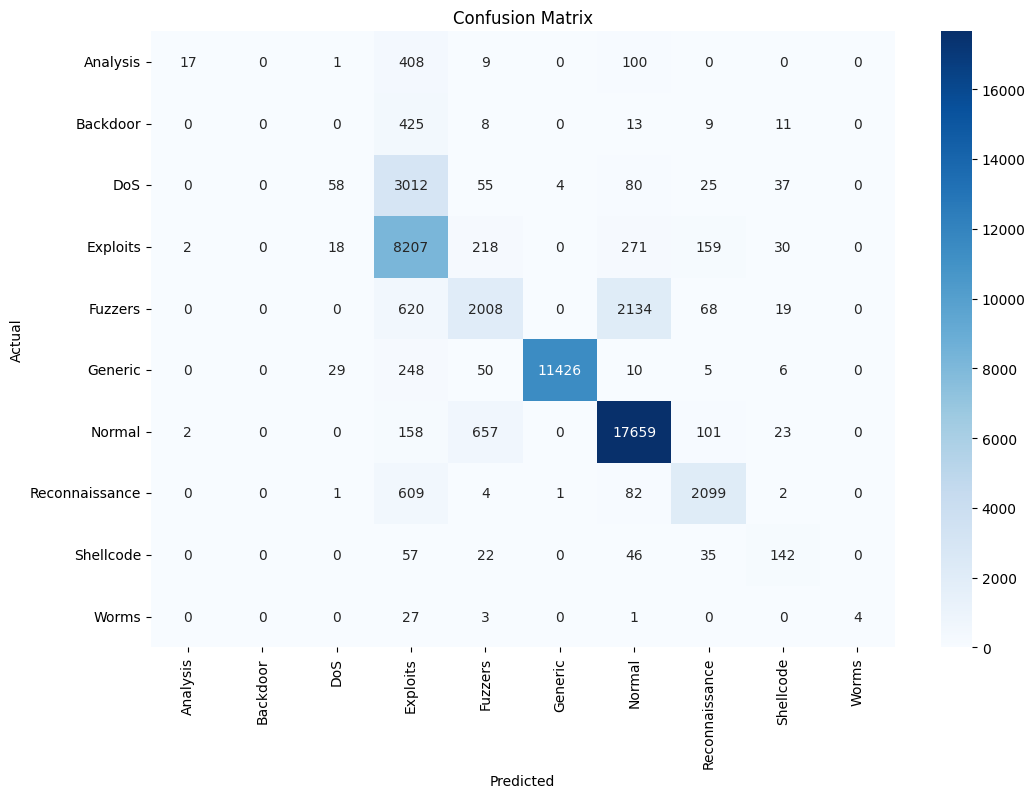

In [10]:

import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df = pd.concat([df_train, df_test], ignore_index=True)

df['attack_cat'] = df['attack_cat'].fillna('Normal')
label_encoder = LabelEncoder()
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])
num_classes = len(label_encoder.classes_)

categorical_cols = ['proto', 'service', 'state']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=['id', 'label', 'attack_cat'], errors='ignore')
X = X.select_dtypes(include=[np.number])
y = df['attack_cat'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

def build_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

clients = 5
X_splits = np.array_split(X_train, clients)
y_splits = np.array_split(y_train_cat, clients)

global_model = build_model(X_train.shape[1], num_classes)

for rnd in range(10):
    print(f"\n🔁 Federated Round {rnd+1}")
    weights = []
    for i in range(clients):
        local_model = clone_model(global_model)
        local_model.set_weights(global_model.get_weights())
        local_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
        local_model.fit(X_splits[i], y_splits[i], epochs=6, batch_size=64, verbose=0, callbacks=[early_stop])

        weights.append(local_model.get_weights())

    new_weights = [np.mean(w, axis=0) for w in zip(*weights)]
    global_model.set_weights(new_weights)

y_pred_probs = global_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n📊 Final Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:

import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from scipy.spatial.distance import cosine
from tensorflow.keras import Input

# ✅ Load dataset
df_train = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df = pd.concat([df_train, df_test], ignore_index=True)

df['attack_cat'] = df['attack_cat'].fillna('Normal')
label_encoder = LabelEncoder()
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])
num_classes = len(label_encoder.classes_)

X = df.drop(columns=['id', 'label', 'attack_cat'], errors='ignore')
y = df['attack_cat']
X = X.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(X, y, timesteps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

timesteps = 10
X_seq, y_seq = create_sequences(X_scaled, y, timesteps)
y_seq_cat = to_categorical(y_seq, num_classes=num_classes)

X_flat = X_seq.reshape((X_seq.shape[0], -1))
df_seq = pd.DataFrame(X_flat)
df_seq['label'] = y_seq
max_count = df_seq['label'].value_counts().max()

balanced = [resample(df_seq[df_seq['label'] == cls], replace=True, n_samples=max_count, random_state=42)
            for cls in df_seq['label'].unique()]
# Instead of using the full `df_bal`
df_bal = df_bal.sample(n=8000, random_state=42)


X_bal = df_bal.drop(columns='label').values.reshape((-1, timesteps, X_seq.shape[2]))
y_bal = df_bal['label'].values
y_bal_cat = to_categorical(y_bal, num_classes=num_classes)

def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


from sklearn.model_selection import StratifiedKFold
clients = 8
skf = StratifiedKFold(n_splits=clients, shuffle=True, random_state=42)
splits = list(skf.split(X_bal, y_bal))
X_splits = [X_bal[train_idx] for train_idx, _ in splits]
y_splits = [y_bal_cat[train_idx] for train_idx, _ in splits]

global_model = build_model((timesteps, X_seq.shape[2]), num_classes)

for rnd in range(5):
    print(f"\n🔁 Federated Round {rnd+1}")
    weights = []
    for i in range(clients):
        local_model = clone_model(global_model)
        local_model.set_weights(global_model.get_weights())
        local_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        local_model.fit(X_splits[i], y_splits[i], epochs=5, verbose=0, batch_size=64)
        weights.append(local_model.get_weights())

    new_weights = []
    for weights_list_tuple in zip(*weights):
        new_weights.append(np.mean(weights_list_tuple, axis=0))
    global_model.set_weights(new_weights)

y_pred_probs = global_model.predict(X_bal, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_bal_cat, axis=1)

print("\n📊 Final Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("\n📡 Real-Time Adaptive Monitoring:")
previous_window = None
drift_threshold = 0.35

for i in range(50):
    x = X_bal[i].reshape(1, timesteps, X_bal.shape[2])
    pred_prob = global_model.predict(x, verbose=0)
    pred_cls = np.argmax(pred_prob)
    true_cls = y_true[i]
    match = "✅" if pred_cls == true_cls else "❌"
    
    print(f"🪟 {i+1}: 🧠 Predicted: {match} {label_encoder.classes_[pred_cls]} | 🛡️ Actual: {label_encoder.classes_[true_cls]}")
    
    if previous_window is not None:
        drift_score = cosine(previous_window, pred_prob.flatten())
        if drift_score > drift_threshold:
            print(f"⚠️ Drift Detected! Score: {drift_score:.4f}")
    previous_window = pred_prob.flatten()



🔁 Federated Round 1

🔁 Federated Round 2

🔁 Federated Round 3

🔁 Federated Round 4

🔁 Federated Round 5

📊 Final Classification Report:
                precision    recall  f1-score   support

      Analysis       0.26      0.15      0.19       799
      Backdoor       0.27      0.31      0.29       784
           DoS       0.23      0.32      0.27       768
      Exploits       0.28      0.06      0.10       765
       Fuzzers       0.26      0.22      0.23       803
       Generic       0.44      0.89      0.59       787
        Normal       0.82      0.96      0.88       914
Reconnaissance       0.29      0.17      0.21       817
     Shellcode       0.24      0.26      0.25       802
         Worms       0.50      0.49      0.49       761

      accuracy                           0.39      8000
     macro avg       0.36      0.38      0.35      8000
  weighted avg       0.37      0.39      0.36      8000


📡 Real-Time Adaptive Monitoring:
🪟 1: 🧠 Predicted: ✅ Reconnaissance | 🛡️ Ac

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from scipy.spatial.distance import cosine
import tensorflow as tf

df_train = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
df = pd.concat([df_train, df_test], ignore_index=True)

df['attack_cat'] = df['attack_cat'].fillna('Normal')
label_encoder = LabelEncoder()
df['attack_cat'] = label_encoder.fit_transform(df['attack_cat'])
num_classes = len(label_encoder.classes_)

X = df.drop(columns=['id', 'label', 'attack_cat'], errors='ignore')
y = df['attack_cat']
X = X.select_dtypes(include=[np.number])
X_scaled = StandardScaler().fit_transform(X)

def create_sequences(X, y, timesteps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

timesteps = 10
X_seq, y_seq = create_sequences(X_scaled, y, timesteps)
y_seq_cat = to_categorical(y_seq, num_classes=num_classes)

X_flat = X_seq.reshape((X_seq.shape[0], -1))
df_seq = pd.DataFrame(X_flat)
df_seq['label'] = y_seq
max_samples_per_class = 800

balanced = [
    resample(df_seq[df_seq['label'] == cls], 
             replace=True, 
             n_samples=max_samples_per_class, 
             random_state=42)
    for cls in df_seq['label'].unique()
]
df_bal = pd.concat(balanced).sample(n=8000, random_state=42)

X_bal = df_bal.drop(columns='label').values.reshape((-1, timesteps, X_seq.shape[2]))
y_bal = df_bal['label'].values
y_bal_cat = to_categorical(y_bal, num_classes=num_classes)

def build_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(32)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(0.0007), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

clients = 8
skf = StratifiedKFold(n_splits=clients, shuffle=True, random_state=42)
splits = list(skf.split(X_bal, y_bal))
X_splits = [X_bal[train_idx] for train_idx, _ in splits]
y_splits = [y_bal_cat[train_idx] for train_idx, _ in splits]

global_model = build_model((timesteps, X_seq.shape[2]), num_classes)


for rnd in range(7):  # More rounds = better convergence
    print(f"\n🔁 Federated Round {rnd+1}")
    weights = []
    for i in range(clients):
        local_model = clone_model(global_model)
        local_model.set_weights(global_model.get_weights())
        local_model.compile(optimizer=Adam(0.0007), loss='categorical_crossentropy', metrics=['accuracy'])
        local_model.fit(X_splits[i], y_splits[i], epochs=7, batch_size=64, verbose=0)
        weights.append(local_model.get_weights())
  
    new_weights = [np.mean(w, axis=0) for w in zip(*weights)]
    global_model.set_weights(new_weights)

y_pred_probs = global_model.predict(X_bal, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_bal_cat, axis=1)
print("\n📊 Final Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("\n📡 Real-Time Adaptive Monitoring:")
previous_window = None
drift_threshold = 0.35
drift_X, drift_y = [], []

for i in range(50):
    x = X_bal[i].reshape(1, timesteps, X_bal.shape[2])
    pred_prob = global_model.predict(x, verbose=0)
    pred_cls = np.argmax(pred_prob)
    true_cls = y_true[i]
    match = "✅" if pred_cls == true_cls else "❌"
    
    print(f"🪟 {i+1}: 🧠 Predicted: {match} {label_encoder.classes_[pred_cls]} | 🛡️ Actual: {label_encoder.classes_[true_cls]}")
    
    if previous_window is not None:
        drift_score = cosine(previous_window, pred_prob.flatten())
        if drift_score > drift_threshold:
            print(f"⚠️ Drift Detected! Score: {drift_score:.4f}")
            drift_X.append(x)
            drift_y.append(to_categorical([true_cls], num_classes=num_classes))
    previous_window = pred_prob.flatten()

    if len(drift_X) >= 10:
        print("🔄 Retraining global model on drifted data...")
        X_drift_batch = np.vstack(drift_X)
        y_drift_batch = np.vstack(drift_y)
        global_model.fit(X_drift_batch, y_drift_batch, epochs=2, verbose=0)
        drift_X.clear()
        drift_y.clear()

global_model.save("federated_ids_model.h5")

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


2025-07-16 15:13:39.772401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752678820.138193      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752678820.235218      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1752678840.345591      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752678840.346386      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:


🔁 Federated Round 1


I0000 00:00:1752678848.092638      97 cuda_dnn.cc:529] Loaded cuDNN version 90300



🔁 Federated Round 2

🔁 Federated Round 3

🔁 Federated Round 4

🔁 Federated Round 5

🔁 Federated Round 6

🔁 Federated Round 7

📊 Final Classification Report:
                precision    recall  f1-score   support

      Analysis       0.66      0.59      0.62       800
      Backdoor       0.61      0.64      0.62       800
           DoS       0.61      0.55      0.58       800
      Exploits       0.64      0.52      0.57       800
       Fuzzers       0.67      0.51      0.58       800
       Generic       0.59      0.93      0.72       800
        Normal       0.96      0.98      0.97       800
Reconnaissance       0.69      0.52      0.59       800
     Shellcode       0.66      0.77      0.71       800
         Worms       0.96      1.00      0.98       800

      accuracy                           0.70      8000
     macro avg       0.70      0.70      0.70      8000
  weighted avg       0.70      0.70      0.70      8000


📡 Real-Time Adaptive Monitoring:
🪟 1: 🧠 Predicted: ❌ A